## Exploratory data analysis for Health data

Main goal of this notebook is to explore the health data related to Asthma and COPD hospitalisations and mortality and find correlation to the smoke data available.

### License:
All code is under MIT license.

Note: Some snippets from this code are taken from ChatGPT to imporve code efficiency.

The below libraries are a pre-requisite to be installed to run the notebook. Uncomment the below cell to install the libraries.

In [19]:
# %pip install seaborn
# %pip install scikit-learn

In [20]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import pearsonr


This section of code reads multiple datasets required for the analysis, including smoke estimates, health-related data (asthma, CO poisoning, COPD hospitalizations, and respiratory disease mortality), and census data. It also filters the data by location (e.g., Alexandria - city level or Virginia-state level) where necessary to focus on the relevant study area.

All the health data is stored in the "raw_data" folder and the processed smoke data is stored under the "intermediary_files" as csv format.

In [21]:
# Read data

# Read smoke estimate data
smoke_estimates_df = pd.read_csv("../intermediary_files/smoke_estimates.csv")

# Read asthma data and filter for Alexandria County
asthma_df = pd.read_csv("../raw_data/Asthma/asthma_data.csv")
asthma_df = asthma_df[asthma_df['County'] == 'Alexandria']

# Read CO poisoning data and filter for Virginia
co_poisoning_df = pd.read_csv("../raw_data/CO_poisoning/CO_poisoning_data.csv")
co_poisoning_df = co_poisoning_df[co_poisoning_df['State'] == 'Virginia']

# Read COPD hospitalization data and filter for Alexandria County
copd_hosp_df = pd.read_csv("../raw_data/COPD_hospitalization/COPD_hospitalization_data.csv")
copd_hosp_df = copd_hosp_df[copd_hosp_df['County'] == 'Alexandria']

# Read respiratory disease mortality data from IHME dataset
ihme_mortality_resp_diseases_df = pd.read_csv(
    "../raw_data/IHME_USA_COUNTY_RESP_DISEASE_MORTALITY_1980_2014_VIRGINIA_Y2017M09D26.CSV"
)

# Read uninsured population data
uninsured_people_df = pd.read_csv("../raw_data/Uninsured People.csv")

# Read census data for various years with appropriate encoding
data_2022 = pd.read_csv("../raw_data/census_data_2022.csv", encoding="latin-1")
data_2021 = pd.read_csv("../raw_data/census_data_2011.csv", encoding="latin-1")
data_2010_2020 = pd.read_csv("../raw_data/census_data_2010_2022.csv", encoding="latin-1")



### Analysis of Census data - Alexandria

This code processes population and mortality data for Alexandria City and Virginia from census datasets spanning 2010–2022. It filters relevant data, extracts population and death columns, reshapes the data into long format, and combines population and death statistics into a unified DataFrame. The resulting dataset is sorted by year, making it ready for analysis of population and mortality trends over time. The death related data I was able to find was limited from 2010 to 2022 - This was a limitation which caused me to reduce my analysis to these years.

In [22]:

# Step 1: Filter data for Alexandria City and Virginia
alexandria_2020 = data_2010_2020[(data_2010_2020['STNAME'] == 'Virginia') & (data_2010_2020['CTYNAME'] == 'Alexandria city')]
virginia_2020 = data_2010_2020[(data_2010_2020['STNAME'] == 'Virginia') & (data_2010_2020['CTYNAME'] == 'Virginia')]

alexandria_2021 = data_2021[(data_2021['STNAME'] == 'Virginia') & (data_2021['CTYNAME'] == 'Alexandria city')]
virginia_2021 = data_2021[(data_2021['STNAME'] == 'Virginia') & (data_2021['CTYNAME'] == 'Virginia')]

alexandria_2022 = data_2022[(data_2022['STNAME'] == 'Virginia') & (data_2022['CTYNAME'] == 'Alexandria city')]
virginia_2022 = data_2022[(data_2022['STNAME'] == 'Virginia') & (data_2022['CTYNAME'] == 'Virginia')]

# Step 2: Extract columns for population and deaths
population_columns_2020 = [col for col in alexandria_2020.columns if "POPESTIMATE" in col]
death_columns_2020 = [col for col in alexandria_2020.columns if "DEATHS" in col]

population_columns_2021_2022 = [col for col in alexandria_2021.columns if "POPESTIMATE" in col]
death_columns_2021_2022 = [col for col in alexandria_2021.columns if "DEATHS" in col]

# Step 3: Melt the data into long format for populations and deaths
alexandria_population = alexandria_2020[population_columns_2020].melt(var_name="Year", value_name="Alexandria_Population")
virginia_population = virginia_2020[population_columns_2020].melt(var_name="Year", value_name="Virginia_Population")

alexandria_deaths = alexandria_2020[death_columns_2020].melt(var_name="Year", value_name="Alexandria_Deaths")
virginia_deaths = virginia_2020[death_columns_2020].melt(var_name="Year", value_name="Virginia_Deaths")

alexandria_population_2021 = alexandria_2021[population_columns_2021_2022].melt(var_name="Year", value_name="Alexandria_Population")
virginia_population_2021 = virginia_2021[population_columns_2021_2022].melt(var_name="Year", value_name="Virginia_Population")

alexandria_deaths_2021 = alexandria_2021[death_columns_2021_2022].melt(var_name="Year", value_name="Alexandria_Deaths")
virginia_deaths_2021 = virginia_2021[death_columns_2021_2022].melt(var_name="Year", value_name="Virginia_Deaths")

alexandria_population_2022 = alexandria_2022[population_columns_2021_2022].melt(var_name="Year", value_name="Alexandria_Population")
virginia_population_2022 = virginia_2022[population_columns_2021_2022].melt(var_name="Year", value_name="Virginia_Population")

alexandria_deaths_2022 = alexandria_2022[death_columns_2021_2022].melt(var_name="Year", value_name="Alexandria_Deaths")
virginia_deaths_2022 = virginia_2022[death_columns_2021_2022].melt(var_name="Year", value_name="Virginia_Deaths")

# Combine data for all years
alexandria_population = pd.concat([alexandria_population, alexandria_population_2021, alexandria_population_2022], ignore_index=True)
virginia_population = pd.concat([virginia_population, virginia_population_2021, virginia_population_2022], ignore_index=True)

alexandria_deaths = pd.concat([alexandria_deaths, alexandria_deaths_2021, alexandria_deaths_2022], ignore_index=True)
virginia_deaths = pd.concat([virginia_deaths, virginia_deaths_2021, virginia_deaths_2022], ignore_index=True)

# Step 4: Combine population and death data into a single DataFrame
census_data_filtered_2010_2022 = alexandria_population.copy()
census_data_filtered_2010_2022['Alexandria_Deaths'] = alexandria_deaths['Alexandria_Deaths']
census_data_filtered_2010_2022['Virginia_Population'] = virginia_population['Virginia_Population']
census_data_filtered_2010_2022['Virginia_Deaths'] = virginia_deaths['Virginia_Deaths']

# Step 5: Clean up 'Year' column to retain only numeric year (e.g., 2010, 2021)
census_data_filtered_2010_2022['Year'] = census_data_filtered_2010_2022['Year'].str.extract('(\d{4})').astype(int)

# Sort the data by year for better readability
census_data_filtered_2010_2022 = census_data_filtered_2010_2022.sort_values(by="Year")

# Display the final dataset
census_data_filtered_2010_2022


<>:51: SyntaxWarning: invalid escape sequence '\d'
<>:51: SyntaxWarning: invalid escape sequence '\d'
/var/folders/ld/y0zsw11s34q_fr6m889pmps40000gp/T/ipykernel_85478/3503892562.py:51: SyntaxWarning: invalid escape sequence '\d'
  census_data_filtered_2010_2022['Year'] = census_data_filtered_2010_2022['Year'].str.extract('(\d{4})').astype(int)


,Year,Alexandria_Population,Alexandria_Deaths,Virginia_Population,Virginia_Deaths
0,2010,140737,211,8024004,14652
1,2011,144269,742,8102437,60455
2,2012,147379,682,8187456,60213
3,2013,149767,732,8255861,63446
4,2014,151544,725,8315430,62616
5,2015,153859,674,8367303,65251
6,2016,156621,719,8417651,65337
7,2017,158772,734,8471011,67942
8,2018,158377,708,8510920,68844
9,2019,159050,733,8556642,70037


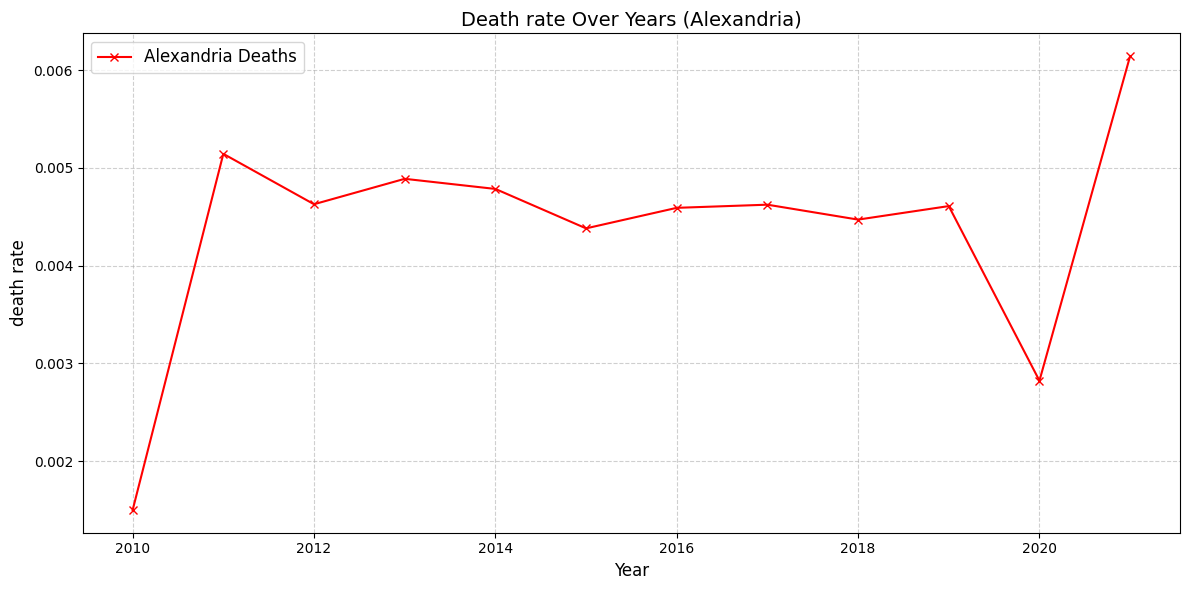

In [23]:
# deaths over the years for alexandria and virginia

# Group data by year (handling duplicate years)
df_grouped = census_data_filtered_2010_2022.groupby("Year").sum()

# Plotting deaths over years for Alexandria and Virginia
plt.figure(figsize=(12, 6))

# Alexandria deaths
plt.plot(
    df_grouped.index, df_grouped["Alexandria_Deaths"]/df_grouped["Alexandria_Population"],
    label="Alexandria Deaths",
    color="red", marker="x", linestyle="-"
)

# Add labels, title, and legend
plt.title("Death rate Over Years (Alexandria)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("death rate", fontsize=12)
plt.legend(fontsize=12, loc="upper left")
plt.grid(alpha=0.6, linestyle="--")

# Show the plot
plt.tight_layout()
plt.show()


The Death rate seem to have a drop during the year 2020, which is a bit strange as I expected it to rise during the COVID year.

### Analysis of Asthma data for Alexandria

Description: Hospitalizations for Asthma | Age-adjusted Rate of Hospitalizations for Asthma per 10,000 Population

- Year available: 2010 - 2022
- Shape of the data is:  (26, 9), that means we have 13 years worth data divided by gender.
- Gender wise - Male and Female for every year we have a value



In [24]:
print("shape of the data is: ", asthma_df.shape)
asthma_df.head()

shape of the data is:  (26, 9)


,StateFIPS,State,CountyFIPS,County,Year,Value,Data Comment,Unnamed: 7,Gender
52,51,Virginia,51510,Alexandria,2010,6.5,NaN,NaN,Male
53,51,Virginia,51510,Alexandria,2010,10.5,NaN,NaN,Female
54,51,Virginia,51510,Alexandria,2011,5.9,NaN,NaN,Male
55,51,Virginia,51510,Alexandria,2011,10.2,NaN,NaN,Female
56,51,Virginia,51510,Alexandria,2012,6.2,NaN,NaN,Male


In [25]:
asthma_df['Year'].value_counts()

Year
2010    2
2011    2
2012    2
2013    2
2014    2
2015    2
2016    2
2017    2
2018    2
2019    2
2020    2
2021    2
2022    2
Name: count, dtype: int64

In [26]:
# Divide the data gender wise for analysis
asthma_male_hosp_df = asthma_df[asthma_df['Gender'] == 'Male'][['Year','Value']].set_index('Year')
asthma_female_hosp_df = asthma_df[asthma_df['Gender'] == 'Female'][['Year','Value']].set_index('Year')

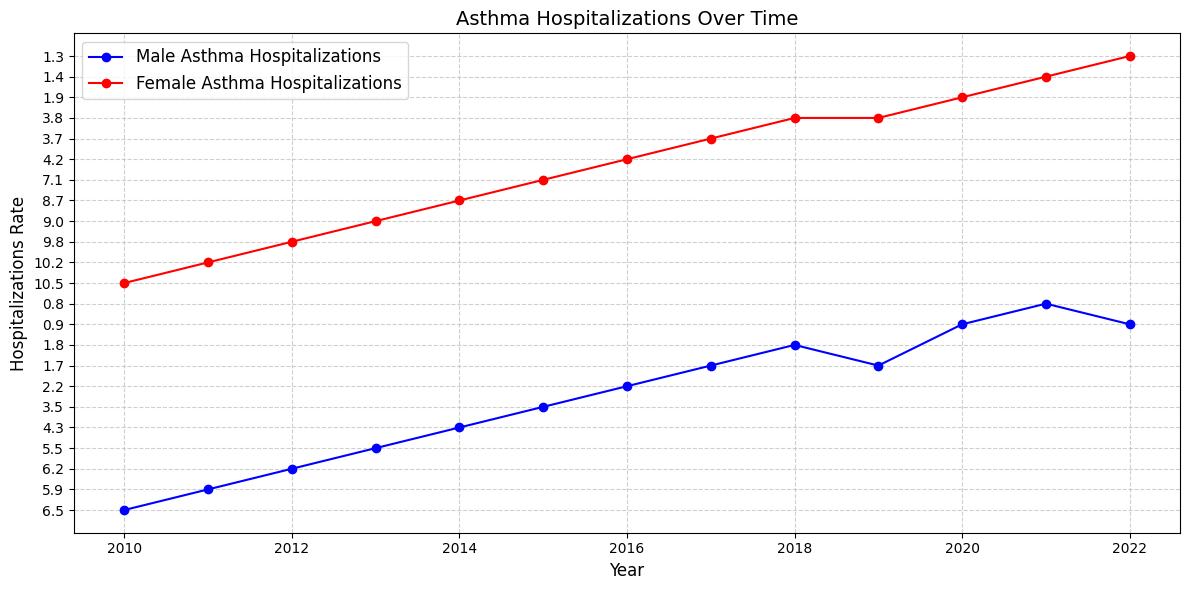

In [27]:

# Plotting
plt.figure(figsize=(12, 6))

# Plot Male Asthma Hospitalizations
plt.plot(
    asthma_male_hosp_df.index,
    asthma_male_hosp_df['Value'],
    color='blue',
    marker='o',
    linestyle='-',
    linewidth=1.5,
    label='Male Asthma Hospitalizations'
)

# Plot Female Asthma Hospitalizations
plt.plot(
    asthma_female_hosp_df.index,
    asthma_female_hosp_df['Value'],
    color='red',
    marker='o',
    linestyle='-',
    linewidth=1.5,
    label='Female Asthma Hospitalizations'
)

# Formatting the chart
plt.title('Asthma Hospitalizations Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Hospitalizations Rate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


### Analysis of CO poisoning data
Hospitalizations for CO Poisoning | Crude Rate of Hospitalizations for CO Poisoning per 100,000 Population

The dataset provides state-level data that needs to be mapped or scaled down to the county level for finer analysis. It has a shape of (26, 7), indicating 26 records across 7 columns. The data spans from 2010 to 2022 and includes cause-wise rates of hospitalization, specifically categorized as fire-related or of unknown intent, though not necessarily linked to wildfires.

In [28]:
print("shape of the data is: ", co_poisoning_df.shape)
co_poisoning_df.head()

shape of the data is:  (26, 7)


,StateFIPS,State,Year,Value,Data Comment,Unnamed: 5,Cause
1196,51,Virginia,2010,0.11,Unstable,NaN,Cause: Fire
1197,51,Virginia,2010,0.11,Unstable,NaN,Cause: Unknown Mechanism or Intent
1198,51,Virginia,2011,0.15,NaN,NaN,Cause: Fire
1199,51,Virginia,2011,0.14,Unstable,NaN,Cause: Unknown Mechanism or Intent
1200,51,Virginia,2012,0.10,Unstable,NaN,Cause: Fire


In [29]:
co_poisoning_df['Year'].value_counts()

Year
2010    2
2011    2
2012    2
2013    2
2014    2
2015    2
2016    2
2017    2
2018    2
2019    2
2020    2
2021    2
2022    2
Name: count, dtype: int64

In [30]:
census_data_filtered_2010_2022

,Year,Alexandria_Population,Alexandria_Deaths,Virginia_Population,Virginia_Deaths
0,2010,140737,211,8024004,14652
1,2011,144269,742,8102437,60455
2,2012,147379,682,8187456,60213
3,2013,149767,732,8255861,63446
4,2014,151544,725,8315430,62616
5,2015,153859,674,8367303,65251
6,2016,156621,719,8417651,65337
7,2017,158772,734,8471011,67942
8,2018,158377,708,8510920,68844
9,2019,159050,733,8556642,70037


To scale the data for Alexandria I have used the census data and used the total population as a scaling factor to compare to the state of Virginia.

In [31]:
co_poisoning_df_scaled = pd.merge(
    co_poisoning_df,
    census_data_filtered_2010_2022,
    how="left",
    left_on="Year",
    right_on="Year"
)

# Scale the "Value" field using Alexandria's and Virginia's populations
co_poisoning_df_scaled['Alexandria_Scaled_Value'] = (
    co_poisoning_df_scaled['Value'] * (co_poisoning_df_scaled['Alexandria_Population']/co_poisoning_df_scaled['Virginia_Population'])
)

co_poisoning_df_scaled.head()

,StateFIPS,State,Year,Value,Data Comment,Unnamed: 5,Cause,Alexandria_Population,Alexandria_Deaths,Virginia_Population,Virginia_Deaths,Alexandria_Scaled_Value
0,51,Virginia,2010,0.11,Unstable,NaN,Cause: Fire,140737.0,211.0,8024004.0,14652.0,0.001929
1,51,Virginia,2010,0.11,Unstable,NaN,Cause: Unknown Mechanism or Intent,140737.0,211.0,8024004.0,14652.0,0.001929
2,51,Virginia,2011,0.15,NaN,NaN,Cause: Fire,144269.0,742.0,8102437.0,60455.0,0.002671
3,51,Virginia,2011,0.14,Unstable,NaN,Cause: Unknown Mechanism or Intent,144269.0,742.0,8102437.0,60455.0,0.002493
4,51,Virginia,2012,0.10,Unstable,NaN,Cause: Fire,147379.0,682.0,8187456.0,60213.0,0.001800


This code filters and processes a scaled dataset to analyze CO poisoning hospitalizations. It separates data based on specific causes, aggregates hospitalization values by year, and organizes the results for year-wise analysis.

In [32]:
co_poisoning_fire_hosp_df = co_poisoning_df_scaled[co_poisoning_df_scaled['Cause'] == 'Cause: Fire'][['Year','Alexandria_Scaled_Value']].set_index('Year')
co_poisoning_unk_hosp_df = co_poisoning_df_scaled[co_poisoning_df_scaled['Cause'] != 'Cause: Fire'][['Year','Alexandria_Scaled_Value']].set_index('Year')

co_poisoning_sum_hosp_df = co_poisoning_df_scaled[['Year', 'Alexandria_Scaled_Value']].groupby('Year')['Alexandria_Scaled_Value'].sum()

In [33]:
co_poisoning_unk_hosp_df

,Alexandria_Scaled_Value
Year,
2010,0.001929
2011,0.002493
2012,0.002340
2013,0.002903
2014,0.002551
2015,0.002942
2016,0.000000
2017,0.000375
2018,0.000000


In [34]:
co_poisoning_sum_hosp_df

Year
2010    0.003859
2011    0.005164
2012    0.004140
2013    0.005261
2014    0.006014
2015    0.004781
2016    0.000372
2017    0.001687
2018    0.000930
2019    0.000744
2020    0.019366
2021    0.003583
2022    0.000000
Name: Alexandria_Scaled_Value, dtype: float64

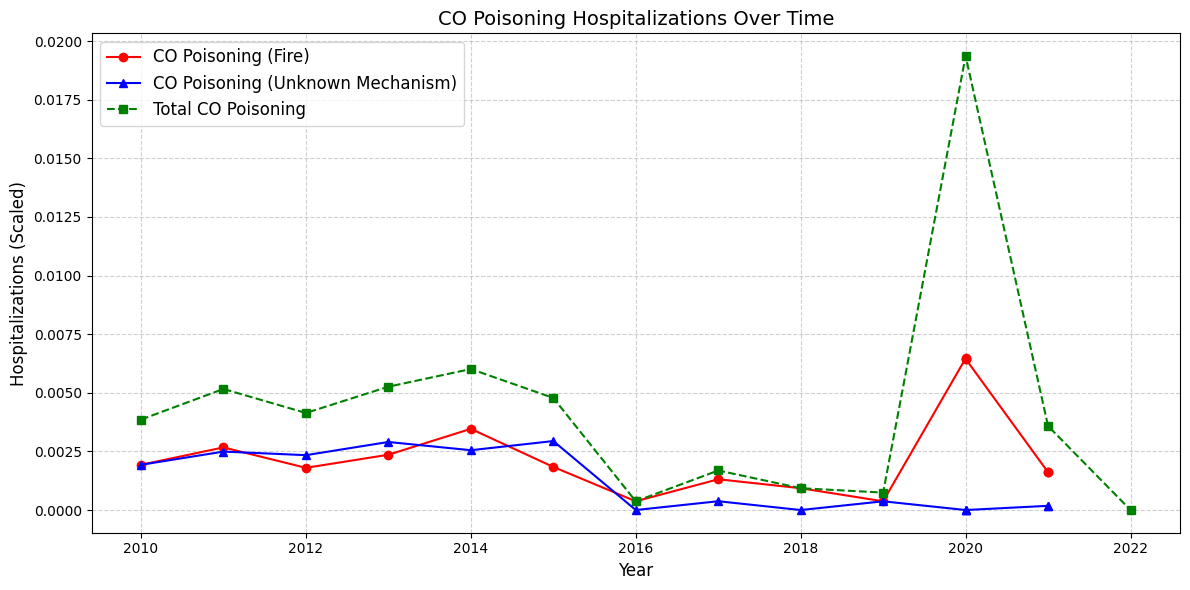

In [35]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot CO Poisoning due to Fire
plt.plot(
    co_poisoning_fire_hosp_df.index,
    co_poisoning_fire_hosp_df['Alexandria_Scaled_Value'],
    color='red',
    marker='o',
    linestyle='-',
    linewidth=1.5,
    label='CO Poisoning (Fire)'
)

# Plot CO Poisoning due to Unknown Mechanism or Intent
plt.plot(
    co_poisoning_unk_hosp_df.index,
    co_poisoning_unk_hosp_df['Alexandria_Scaled_Value'],
    color='blue',
    marker='^',
    linestyle='-',
    linewidth=1.5,
    label='CO Poisoning (Unknown Mechanism)'
)

# Plot Total CO Poisoning
plt.plot(
    co_poisoning_sum_hosp_df.index,
    co_poisoning_sum_hosp_df,
    color='green',
    marker='s',
    linestyle='--',
    linewidth=1.5,
    label='Total CO Poisoning'
)

# Formatting the chart
plt.title('CO Poisoning Hospitalizations Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Hospitalizations (Scaled)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


The CO poisoning due to fire could be for multiple reasons and the hospitalisation rate after scaling does not seem to be that impactful.

### Analysis for COPD hospitalisation

The dataset on Chronic Obstructive Pulmonary Disease (COPD) hospitalizations includes age-adjusted rates for individuals aged 25 and older, measured per 10,000 population. It uses state and local public health data to monitor trends, assess disease burden, and identify high-risk groups. 

- shape of the data is:  (26, 9)
- year 2010 to 2022
- Gender wise data - same as asthma

In [36]:
copd_hosp_df.head()

,StateFIPS,State,CountyFIPS,County,Year,Value,Data Comment,Unnamed: 7,Gender
52,51,Virginia,51510,Alexandria,2010,9.9,NaN,NaN,Male
53,51,Virginia,51510,Alexandria,2010,9.1,NaN,NaN,Female
54,51,Virginia,51510,Alexandria,2011,10.8,NaN,NaN,Male
55,51,Virginia,51510,Alexandria,2011,12.1,NaN,NaN,Female
56,51,Virginia,51510,Alexandria,2012,9.8,NaN,NaN,Male


In [37]:
copd_hosp_df['Year'].value_counts()

Year
2010    2
2011    2
2012    2
2013    2
2014    2
2015    2
2016    2
2017    2
2018    2
2019    2
2020    2
2021    2
2022    2
Name: count, dtype: int64

In [38]:
copd_male_hosp_df = copd_hosp_df[copd_hosp_df['Gender'] == 'Male'][['Year','Value']].set_index('Year')
copd_female_hosp_df = copd_hosp_df[copd_hosp_df['Gender'] == 'Female'][['Year','Value']].set_index('Year')

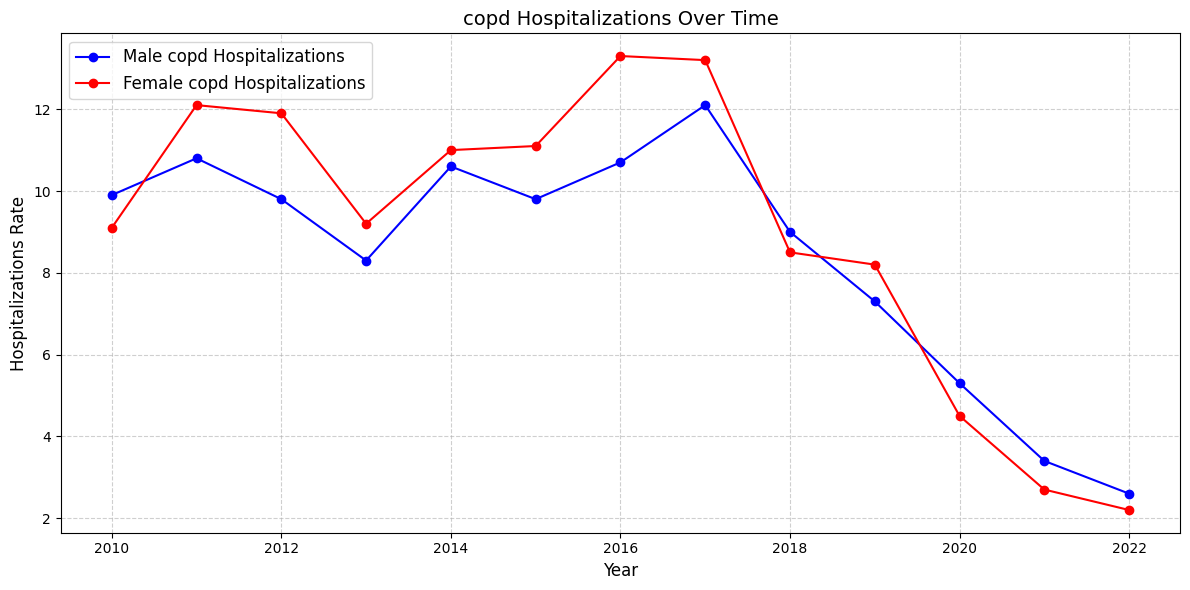

In [39]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot Male copd Hospitalizations
plt.plot(
    copd_male_hosp_df.index,
    copd_male_hosp_df['Value'],
    color='blue',
    marker='o',
    linestyle='-',
    linewidth=1.5,
    label='Male copd Hospitalizations'
)

# Plot Female copd Hospitalizations
plt.plot(
    copd_female_hosp_df.index,
    copd_female_hosp_df['Value'],
    color='red',
    marker='o',
    linestyle='-',
    linewidth=1.5,
    label='Female copd Hospitalizations'
)

# Formatting the chart
plt.title('copd Hospitalizations Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Hospitalizations Rate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

### Smoke estimates

Below we read the smoke estimates we calculated in the part 1 analysis of this project. The data is available from 1961 to 2020.

In [40]:
smoke_estimates_df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,year,name,size,type,circleness_scale,avg_distance,perimeter_start,shortest_distance,shortest_latlon,fire_type_encoded,smoke_estimate
0,0,13778,1961-13778-W_C_H_4_3_W1_61 (2),1961,W_C_H_4_3_W1_61 (2),28.693900,Wildfire,0.648984,426.356838,"(35.675731798257715, -83.71589029532807)",426.159008,"(35.67698964517509, -83.70966687469813)",5,0.193407
1,1,13792,1961-13792-FALL BRANC (2),1961,FALL BRANC (2),13.973044,Wildfire,0.580768,428.070862,"(35.658386536996765, -83.73666367421406)",427.994728,"(35.658889182769094, -83.7342160693799)",5,0.088211
2,2,13809,1961-13809-WORLEY KNO (2),1961,WORLEY KNO (2),6.655655,Wildfire,0.745906,420.876349,"(35.46030766855338, -83.41782178915307)",420.797336,"(35.460386527612144, -83.41673215456898)",5,0.049266
3,3,13810,1961-13810-CW_H_4_2_W12_61 (2),1961,CW_H_4_2_W12_61 (2),6.387265,Wildfire,0.761103,439.836810,"(35.60967334366376, -83.9442967311793)",439.793960,"(35.60967334366376, -83.9442967311793)",5,0.045788
4,4,13836,1961-13836-FOOTHILLS (2),1961,FOOTHILLS (2),1.527601,Wildfire,0.782713,435.545571,"(35.670698246564235, -83.90266194869604)",435.501251,"(35.671137177075195, -83.90149204817143)",5,0.011248


In [41]:
smoke_estimates_df['year'].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020])

In [42]:
smoke_estimates_mean_df = smoke_estimates_df.groupby('year')['smoke_estimate'].mean()

smoke_estimates_mean_df

year
1961     0.167383
1962     6.096890
1963     8.177903
1964     0.150089
1965     0.235114
1966     0.069257
1967     0.997449
1968     0.789350
1969     0.528641
1970     1.948496
1971     1.670289
1972     0.091170
1973     0.241034
1974     0.232841
1975     0.217733
1976     0.403352
1977     0.705933
1978     1.133789
1979     0.400432
1980     1.503642
1981     0.339768
1982     0.169309
1983     0.265882
1984     0.301352
1985     9.933734
1986     5.208134
1987    14.344790
1988     1.562067
1989     2.056334
1990     1.335250
1991    11.481725
1992     1.787157
1993     0.794031
1994     2.627775
1995     1.460549
1996     0.721129
1997     1.128573
1998     1.429996
1999     4.312745
2000     4.785781
2001     3.680451
2002     3.504561
2003     1.388726
2004     2.583652
2005     2.391969
2006     2.194324
2007     3.178286
2008     3.227927
2009     2.120966
2010     1.867397
2011     5.803643
2012     3.229545
2013     1.327063
2014     1.328153
2015     1.124637
2016 

We filter for the years after 2010 as rest of the health data we have is from 2010

In [43]:
smoke_estimates_after_2010_df = smoke_estimates_mean_df.loc[2010:]

In [44]:
annual_mean_smoke_estimate = smoke_estimates_after_2010_df

In [45]:
annual_mean_smoke_estimate

year
2010    1.867397
2011    5.803643
2012    3.229545
2013    1.327063
2014    1.328153
2015    1.124637
2016    2.976508
2017    2.405600
2018    1.329499
2019    1.029110
2020    0.855885
Name: smoke_estimate, dtype: float64

### Correlations for smoke estimates with hospitalizations

In [46]:
# smoke estimates with asthma hospitalization

# Male population
male_corr_mean_smoke_est = asthma_male_hosp_df['Value'].corr(annual_mean_smoke_estimate)

print(f"Correlation for asthma hospitalisation in Males with mean smoke estimates: {male_corr_mean_smoke_est}")

# Female population
female_corr_mean_smoke_est = asthma_female_hosp_df['Value'].corr(annual_mean_smoke_estimate)

print(f"Correlation for asthma hospitalisation in females with mean smoke estimates: {female_corr_mean_smoke_est}")

Correlation for asthma hospitalisation in Males with mean smoke estimates: 0.450171597578171
Correlation for asthma hospitalisation in females with mean smoke estimates: 0.4332162576041932


In [47]:
# Ensure the series are aligned and have the same length
male_values = asthma_male_hosp_df['Value']
female_values = asthma_female_hosp_df['Value']

# Align indices and ensure matching lengths
male_values_aligned, annual_mean_smoke_estimate_aligned = male_values.align(annual_mean_smoke_estimate, join='inner')
female_values_aligned, annual_mean_smoke_estimate_aligned = female_values.align(annual_mean_smoke_estimate, join='inner')

# Male population
male_corr_mean_smoke_est, male_p_value = pearsonr(male_values_aligned, annual_mean_smoke_estimate_aligned)
print(f"Correlation for asthma hospitalisation in Males with mean smoke estimates: {male_corr_mean_smoke_est}, p-value: {male_p_value}")

# Female population
female_corr_mean_smoke_est, female_p_value = pearsonr(female_values_aligned, annual_mean_smoke_estimate_aligned)
print(f"Correlation for asthma hospitalisation in Females with mean smoke estimates: {female_corr_mean_smoke_est}, p-value: {female_p_value}")


ValueError: data type <class 'numpy.object_'> not inexact

There is a moderate positive relationship between mean smoke estimates and male asthma hospitalizations, but the result is not statistically significant. This means the observed correlation could have occurred by chance, and we cannot confidently claim a strong linear relationship.

In [ ]:
# smoke estimates with CO poisoning hospitalization

# Cause was fire
co_poisoning_fire_mean_smoke_est = co_poisoning_fire_hosp_df['Alexandria_Scaled_Value'].corr(annual_mean_smoke_estimate)

print(f"Correlation for CO poisoning hospitalization with cause of fire with mean smoke estimates: {co_poisoning_fire_mean_smoke_est}")


# Cause was unknown
co_poisoning_unk_mean_smoke_est = co_poisoning_unk_hosp_df['Alexandria_Scaled_Value'].corr(annual_mean_smoke_estimate)

print(f"Correlation for CO poisoning hospitalization with cause of unk with mean smoke estimates: {co_poisoning_unk_mean_smoke_est}")

# Sum of causes
co_poisoning_sum_mean_smoke_est = co_poisoning_sum_hosp_df.corr(annual_mean_smoke_estimate)

print(f"Correlation for CO poisoning hospitalization when sum with mean smoke estimates: {co_poisoning_sum_mean_smoke_est}")



Correlation for CO poisoning hospitalization with cause of fire with mean smoke estimates: -0.335116610956831
Correlation for CO poisoning hospitalization with cause of unk with mean smoke estimates: 0.3156499478519908
Correlation for CO poisoning hospitalization when sum with mean smoke estimates: -0.20946493463534668


The correlation between CO poisoning hospitalizations and mean smoke estimates varies by cause. Fire-related hospitalizations show negative slight correlation, while unknown causes exhibit a moderate positive correlation, and the overall sum shows a weak positive relationship.

In [ ]:
# smoke estimates with copd hospitalization

# Male population
copd_male_corr_mean_smoke_est = copd_male_hosp_df['Value'].corr(annual_mean_smoke_estimate)

print(f"Correlation for copd hospitalisation in Males with mean smoke estimates: {copd_male_corr_mean_smoke_est}")

# Female population
copd_female_corr_mean_smoke_est = copd_female_hosp_df['Value'].corr(annual_mean_smoke_estimate)

print(f"Correlation for copd hospitalisation in females with mean smoke estimates: {copd_female_corr_mean_smoke_est}")

Correlation for copd hospitalisation in Males with mean smoke estimates: 0.5328722723738952
Correlation for copd hospitalisation in females with mean smoke estimates: 0.5944642912059283


COPD hospitalizations exhibit a strong positive correlation with mean smoke estimates for both males and females, with a slightly stronger relationship observed in females. This suggests a significant association between smoke exposure and COPD outcomes.

In [ ]:
# Ensure the series are aligned and have the same length
male_values = copd_male_hosp_df['Value']
female_values = copd_female_hosp_df['Value']

# Align indices and ensure matching lengths
male_values_aligned, annual_mean_smoke_estimate_aligned = male_values.align(annual_mean_smoke_estimate, join='inner')
female_values_aligned, annual_mean_smoke_estimate_aligned = female_values.align(annual_mean_smoke_estimate, join='inner')

# Male population
male_corr_mean_smoke_est, male_p_value = pearsonr(male_values_aligned, annual_mean_smoke_estimate_aligned)
print(f"Correlation for COPD hospitalisation in Males with mean smoke estimates: {male_corr_mean_smoke_est}, p-value: {male_p_value}")

# Female population
female_corr_mean_smoke_est, female_p_value = pearsonr(female_values_aligned, annual_mean_smoke_estimate_aligned)
print(f"Correlation for COPD hospitalisation in Females with mean smoke estimates: {female_corr_mean_smoke_est}, p-value: {female_p_value}")


Correlation for asthma hospitalisation in Males with mean smoke estimates: 0.5328722723738953, p-value: 0.0914558023280026
Correlation for asthma hospitalisation in Females with mean smoke estimates: 0.5944642912059281, p-value: 0.05375549834794592


The correlations indicate a moderate to strong positive relationship between asthma hospitalizations and mean smoke estimates for both males (0.53) and females (0.59). However, the p-values (0.09 for males and 0.05 for females) suggest that the correlation is not statistically significant at the conventional 0.05 level for males, while it is borderline significant for females. This indicates a possible association, especially for females, but further data or analysis would be needed to confirm these findings with stronger statistical confidence.

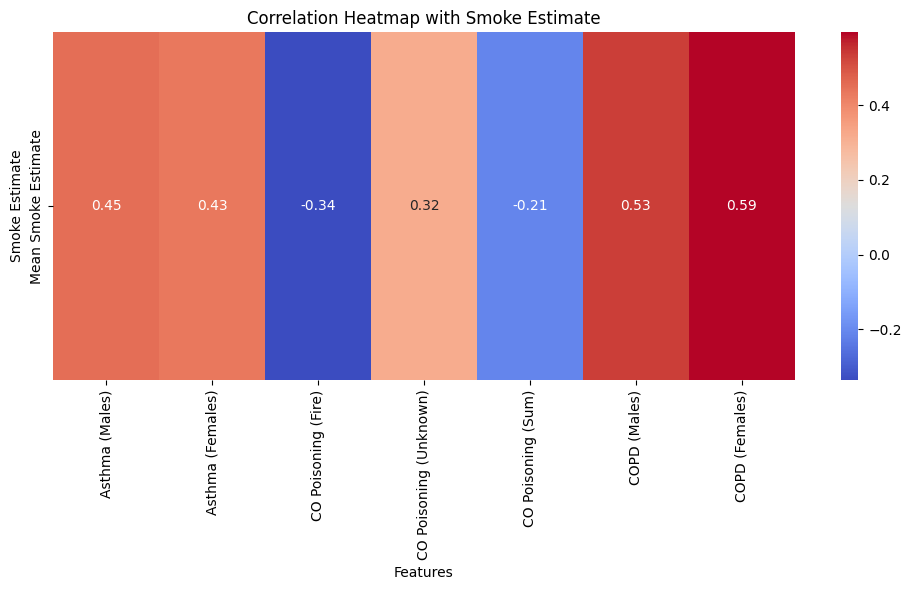

In [ ]:
# Create a dictionary of variables and their correlations
correlation_data = {
    "Asthma (Males)": asthma_male_hosp_df['Value'].corr(annual_mean_smoke_estimate),
    "Asthma (Females)": asthma_female_hosp_df['Value'].corr(annual_mean_smoke_estimate),
    "CO Poisoning (Fire)": co_poisoning_fire_hosp_df['Alexandria_Scaled_Value'].corr(annual_mean_smoke_estimate),
    "CO Poisoning (Unknown)": co_poisoning_unk_hosp_df['Alexandria_Scaled_Value'].corr(annual_mean_smoke_estimate),
    "CO Poisoning (Sum)": co_poisoning_sum_hosp_df.corr(annual_mean_smoke_estimate),
    "COPD (Males)": copd_male_hosp_df['Value'].corr(annual_mean_smoke_estimate),
    "COPD (Females)": copd_female_hosp_df['Value'].corr(annual_mean_smoke_estimate),
}

# Convert the dictionary to a DataFrame
correlation_df = pd.DataFrame(correlation_data, index=["Mean Smoke Estimate"])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", cbar=True, fmt=".2f")
plt.title("Correlation Heatmap with Smoke Estimate")
plt.xlabel("Features")
plt.ylabel("Smoke Estimate")
plt.tight_layout()
plt.show()


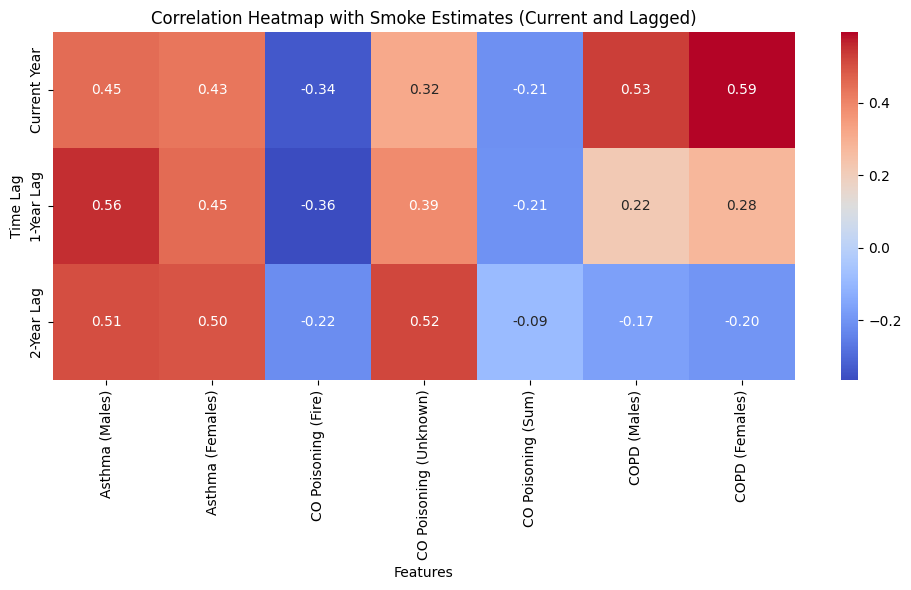

In [ ]:
# Step 1: Prepare lagged smoke estimates
smoke_estimate_lagged_1 = annual_mean_smoke_estimate.shift(1)  # 1-year lag
smoke_estimate_lagged_2 = annual_mean_smoke_estimate.shift(2)  # 2-year lag

# Step 2: Compute correlations with lagged smoke estimates
correlation_data_lagged_1 = {
    "Asthma (Males)": asthma_male_hosp_df['Value'].corr(smoke_estimate_lagged_1),
    "Asthma (Females)": asthma_female_hosp_df['Value'].corr(smoke_estimate_lagged_1),
    "CO Poisoning (Fire)": co_poisoning_fire_hosp_df['Alexandria_Scaled_Value'].corr(smoke_estimate_lagged_1),
    "CO Poisoning (Unknown)": co_poisoning_unk_hosp_df['Alexandria_Scaled_Value'].corr(smoke_estimate_lagged_1),
    "CO Poisoning (Sum)": co_poisoning_sum_hosp_df.corr(smoke_estimate_lagged_1),
    "COPD (Males)": copd_male_hosp_df['Value'].corr(smoke_estimate_lagged_1),
    "COPD (Females)": copd_female_hosp_df['Value'].corr(smoke_estimate_lagged_1),
}

correlation_data_lagged_2 = {
    "Asthma (Males)": asthma_male_hosp_df['Value'].corr(smoke_estimate_lagged_2),
    "Asthma (Females)": asthma_female_hosp_df['Value'].corr(smoke_estimate_lagged_2),
    "CO Poisoning (Fire)": co_poisoning_fire_hosp_df['Alexandria_Scaled_Value'].corr(smoke_estimate_lagged_2),
    "CO Poisoning (Unknown)": co_poisoning_unk_hosp_df['Alexandria_Scaled_Value'].corr(smoke_estimate_lagged_2),
    "CO Poisoning (Sum)": co_poisoning_sum_hosp_df.corr(smoke_estimate_lagged_2),
    "COPD (Males)": copd_male_hosp_df['Value'].corr(smoke_estimate_lagged_2),
    "COPD (Females)": copd_female_hosp_df['Value'].corr(smoke_estimate_lagged_2),
}

# Step 3: Convert data into a DataFrame
correlation_df = pd.DataFrame({
    "Current Year": correlation_data,
    "1-Year Lag": correlation_data_lagged_1,
    "2-Year Lag": correlation_data_lagged_2
})

# Step 4: Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df.T, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap with Smoke Estimates (Current and Lagged)")
plt.xlabel("Features")
plt.ylabel("Time Lag")
plt.tight_layout()
plt.show()


The heatmap reveals that asthma and COPD hospitalizations show moderate to strong correlations with current and 1-year lagged smoke estimates, indicating more immediate impacts of smoke exposure on these conditions. In contrast, CO poisoning due to unknown causes exhibits a stronger delayed effect, with the highest correlation at a 2-year lag. CO poisoning from fire shows weak or negative correlations across all time lags, suggesting other factors influence these hospitalizations. Overall, the findings emphasize the need to account for delayed effects when analyzing smoke-related health outcomes.

### Mortality data analysis

#### Analysis of Mortality data - IHME

The IHME dataset provides age-standardized mortality estimates for chronic respiratory diseases by county, based on de-identified death records, population data, and disease classifications from the Global Burden of Disease Study.

- data available from 1980-2014
- Causes of death: 'Chronic respiratory diseases',
       'Chronic obstructive pulmonary disease', 'Pneumoconiosis',
       'Silicosis', 'Asbestosis', 'Coal workers pneumoconiosis',
       'Other pneumoconiosis', 'Asthma',
       'Interstitial lung disease and pulmonary sarcoidosis',
       'Other chronic respiratory diseases'

In [49]:
ihme_mortality_resp_diseases_df.head()

,measure_id,measure_name,location_id,location_name,FIPS,cause_id,cause_name,sex_id,sex,age_id,age_name,year_id,metric,mx,lower,upper
0,1,Deaths,569,Virginia,51,508,Chronic respiratory diseases,1,Male,27,Age-standardized,1980,Rate,75.987977,73.526281,78.306861
1,1,Deaths,569,Virginia,51,508,Chronic respiratory diseases,1,Male,27,Age-standardized,1981,Rate,75.134218,72.724434,77.449527
2,1,Deaths,569,Virginia,51,508,Chronic respiratory diseases,1,Male,27,Age-standardized,1982,Rate,74.182645,71.939490,76.395129
3,1,Deaths,569,Virginia,51,508,Chronic respiratory diseases,1,Male,27,Age-standardized,1983,Rate,75.117868,72.910668,77.289156
4,1,Deaths,569,Virginia,51,508,Chronic respiratory diseases,1,Male,27,Age-standardized,1984,Rate,75.279177,73.103803,77.318773


In [50]:
# list of respiratoey mortality causes
ihme_mortality_resp_diseases_df['cause_name'].unique()

array(['Chronic respiratory diseases',
       'Chronic obstructive pulmonary disease', 'Pneumoconiosis',
       'Silicosis', 'Asbestosis', 'Coal workers pneumoconiosis',
       'Other pneumoconiosis', 'Asthma',
       'Interstitial lung disease and pulmonary sarcoidosis',
       'Other chronic respiratory diseases'], dtype=object)

In [51]:
# number of years data is available for
ihme_mortality_resp_diseases_df['year_id'].unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014])

In [52]:
mortality_resp_diseases_alexandria_df = ihme_mortality_resp_diseases_df[ihme_mortality_resp_diseases_df['location_name'] == 'Alexandria City']

In [53]:
mortality_resp_diseases_alexandria_df.head()

,measure_id,measure_name,location_id,location_name,FIPS,cause_id,cause_name,sex_id,sex,age_id,age_name,year_id,metric,mx,lower,upper
10080,1,Deaths,3405,Alexandria City,51510,508,Chronic respiratory diseases,1,Male,27,Age-standardized,1980,Rate,71.639314,65.376591,77.709019
10081,1,Deaths,3405,Alexandria City,51510,508,Chronic respiratory diseases,1,Male,27,Age-standardized,1981,Rate,68.430904,63.002847,74.146541
10082,1,Deaths,3405,Alexandria City,51510,508,Chronic respiratory diseases,1,Male,27,Age-standardized,1982,Rate,68.362195,62.665742,74.387193
10083,1,Deaths,3405,Alexandria City,51510,508,Chronic respiratory diseases,1,Male,27,Age-standardized,1983,Rate,66.891821,61.600060,72.529090
10084,1,Deaths,3405,Alexandria City,51510,508,Chronic respiratory diseases,1,Male,27,Age-standardized,1984,Rate,65.500750,60.520264,70.614728


The mortality data is standardized for age we build our analysis in the future if we get age wise mortality for respiratory diseases.

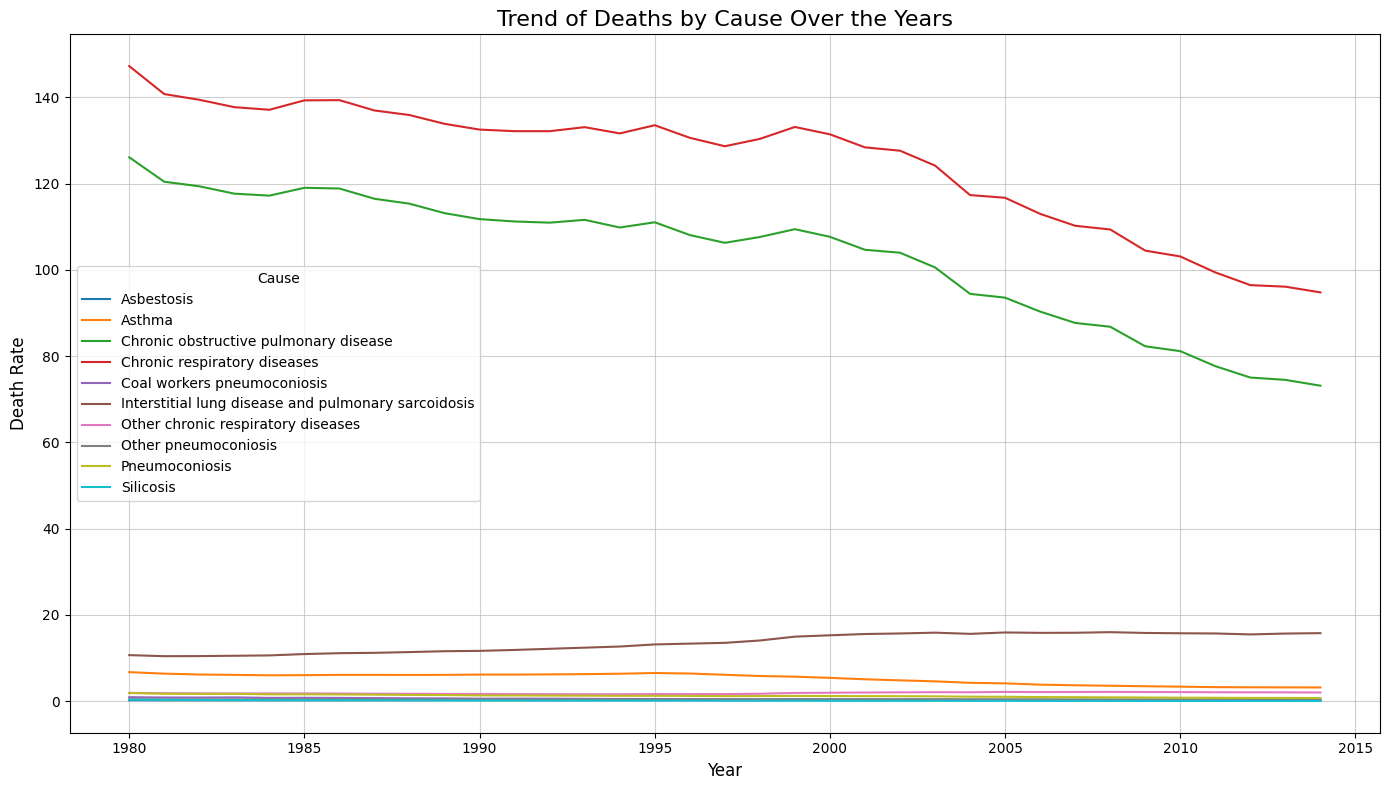

In [54]:
# Group mortality data by year and cause_name and sum the number of deaths
mortality_trend = mortality_resp_diseases_alexandria_df.groupby(['year_id', 'cause_name'])['mx'].sum().reset_index()

# Rename columns for clarity
mortality_trend.rename(columns={'year_id': 'Year', 'cause_name': 'Cause', 'mx': 'Deaths'}, inplace=True)

# Pivot the data for visualization
mortality_trend_pivot = mortality_trend.pivot(index='Year', columns='Cause', values='Deaths')

# Plotting the trend for each cause over the years
plt.figure(figsize=(14, 8))

# Plot each cause
for cause in mortality_trend_pivot.columns:
    plt.plot(mortality_trend_pivot.index, mortality_trend_pivot[cause], label=cause)

# Add titles and labels
plt.title('Trend of Deaths by Cause Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Death Rate', fontsize=12)
plt.legend(title='Cause', fontsize=10)
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()


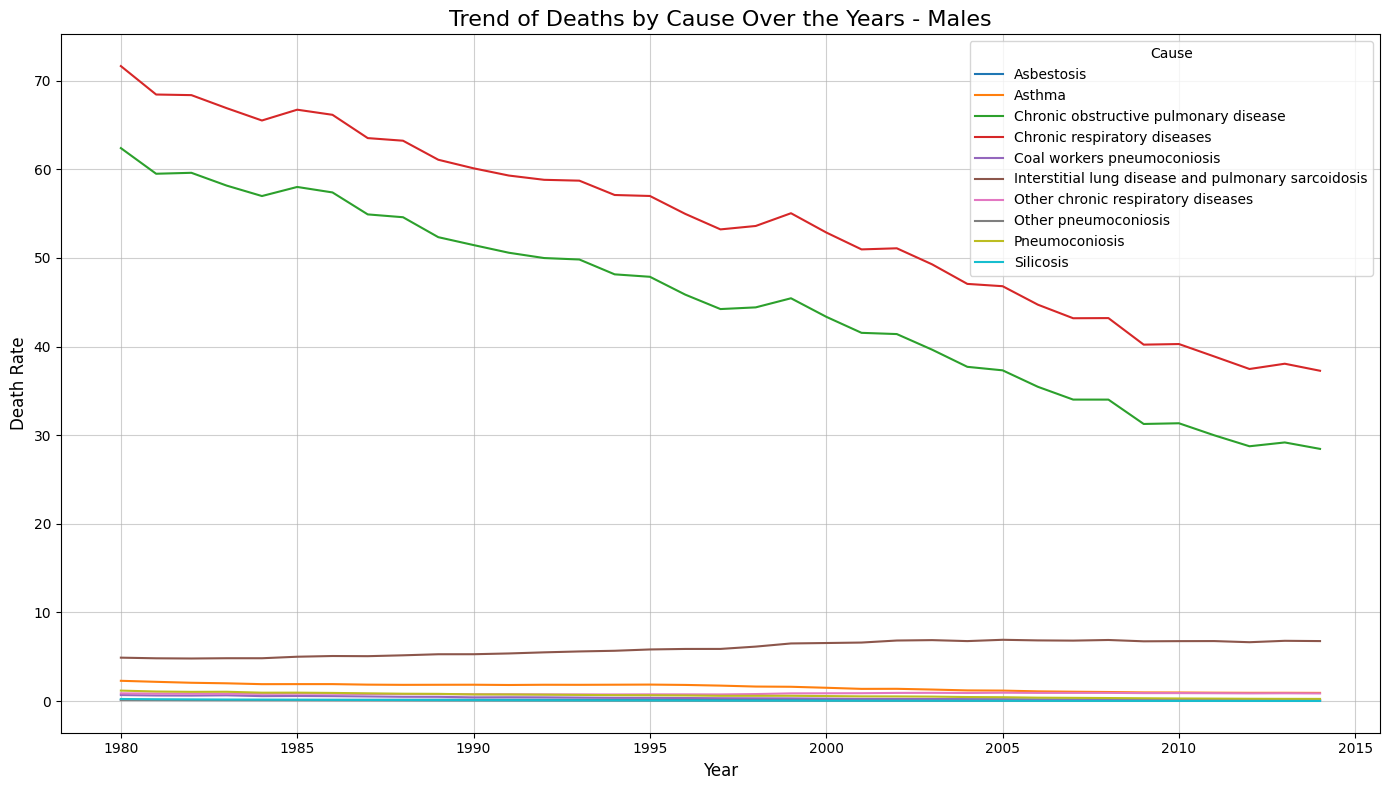

In [55]:
# mortality based on gender

# Group mortality data by year and cause_name and sum the number of deaths
mortality_male = mortality_resp_diseases_alexandria_df[mortality_resp_diseases_alexandria_df['sex'] == 'Male']
mortality_trend_male = mortality_male.groupby(['year_id', 'cause_name'])['mx'].sum().reset_index()

# Rename columns for clarity
mortality_trend_male.rename(columns={'year_id': 'Year', 'cause_name': 'Cause', 'mx': 'Deaths'}, inplace=True)

# Pivot the data for visualization
mortality_trend_male_pivot = mortality_trend_male.pivot(index='Year', columns='Cause', values='Deaths')

# Plotting the trend for each cause over the years
plt.figure(figsize=(14, 8))

# Plot each cause
for cause in mortality_trend_male_pivot.columns:
    plt.plot(mortality_trend_male_pivot.index, mortality_trend_male_pivot[cause], label=cause)

# Add titles and labels
plt.title('Trend of Deaths by Cause Over the Years - Males', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Death Rate', fontsize=12)
plt.legend(title='Cause', fontsize=10)
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()

Above chart illustrates the trends in death rates for various respiratory diseases among males over the years. Chronic respiratory diseases (red line) and chronic obstructive pulmonary disease (green line) have the highest death rates, with a gradual decline observed for both causes after the 1990s. Other causes, such as asthma and pneumoconiosis, maintain consistently low death rates throughout the period, with minimal variation.

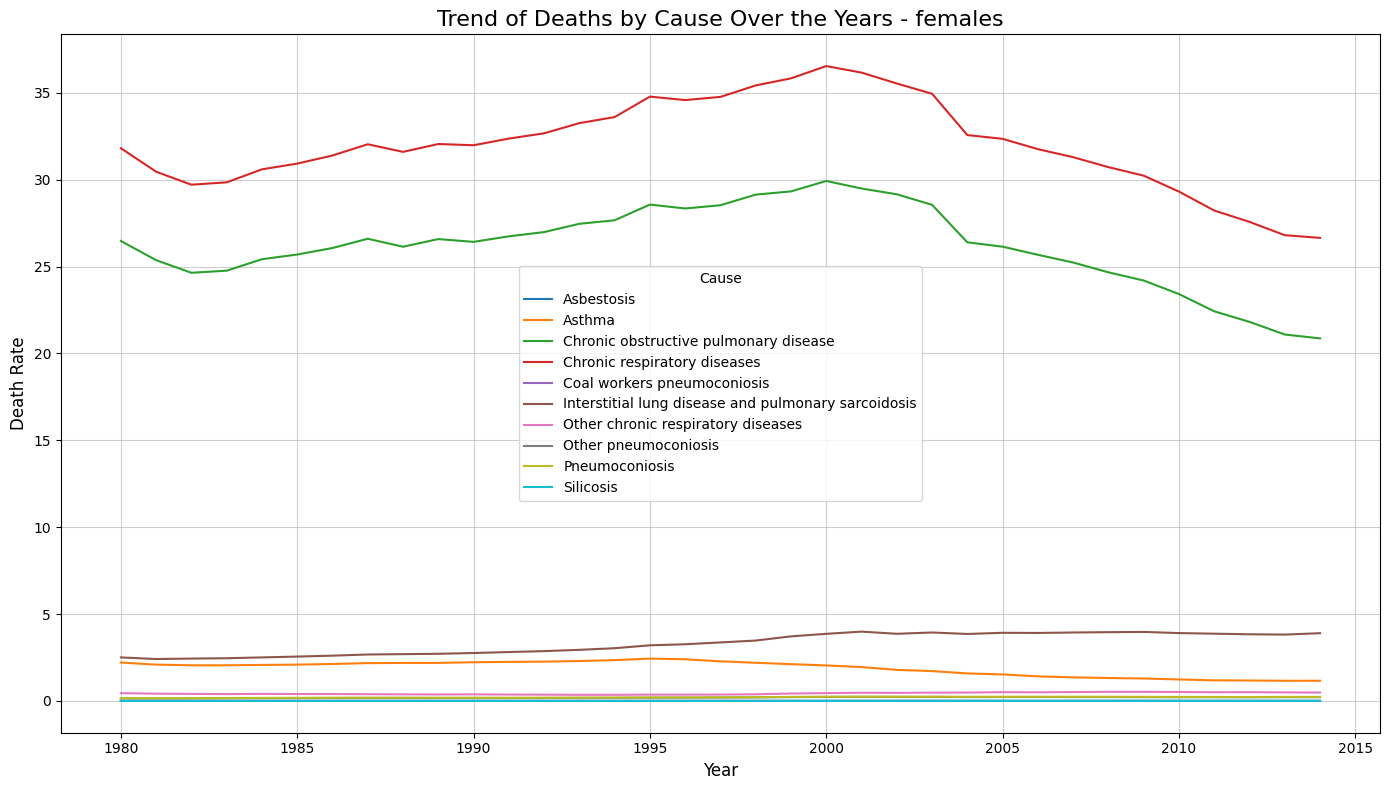

In [56]:
# Group mortality data by year and cause_name and sum the number of deaths
mortality_female = mortality_resp_diseases_alexandria_df[mortality_resp_diseases_alexandria_df['sex'] == 'Female']
mortality_trend_female = mortality_female.groupby(['year_id', 'cause_name'])['mx'].sum().reset_index()

# Rename columns for clarity
mortality_trend_female.rename(columns={'year_id': 'Year', 'cause_name': 'Cause', 'mx': 'Deaths'}, inplace=True)

# Pivot the data for visualization
mortality_trend_female_pivot = mortality_trend_female.pivot(index='Year', columns='Cause', values='Deaths')

# Plotting the trend for each cause over the years
plt.figure(figsize=(14, 8))

# Plot each cause
for cause in mortality_trend_female_pivot.columns:
    plt.plot(mortality_trend_female_pivot.index, mortality_trend_female_pivot[cause], label=cause)

# Add titles and labels
plt.title('Trend of Deaths by Cause Over the Years - females', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Death Rate', fontsize=12)
plt.legend(title='Cause', fontsize=10)
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()

Above chart shows the trend of death rates for various respiratory diseases among females over the years. Chronic obstructive pulmonary disease (green line) and interstitial lung disease/pulmonary sarcoidosis (red line) have the highest death rates, with interstitial lung disease peaking around the mid-2000s and then declining. Other causes, such as asthma and pneumoconiosis, have consistently low death rates throughout the period, with minimal variation.

/var/folders/ld/y0zsw11s34q_fr6m889pmps40000gp/T/ipykernel_85478/2891515246.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortality_data_filtered.rename(columns={'year_id': 'year'}, inplace=True)


Correlation for Both: 0.001600341459479919
Correlation for Female: 0.0006827672027203559
Correlation for Male: 0.003510596648692977
Correlation for Asbestosis: 0.0008764527833524048
Correlation for Asthma: 0.02176975129914778
Correlation for Chronic obstructive pulmonary disease: 0.01887172642184499
Correlation for Chronic respiratory diseases: 0.016169880181400784
Correlation for Coal workers pneumoconiosis: 0.01605798038169587
Correlation for Interstitial lung disease and pulmonary sarcoidosis: -0.01507519462954142
Correlation for Other chronic respiratory diseases: -0.006084595603974654
Correlation for Other pneumoconiosis: 0.0016414005768963925
Correlation for Pneumoconiosis: 0.01695447372695166
Correlation for Silicosis: 0.01730646317324887


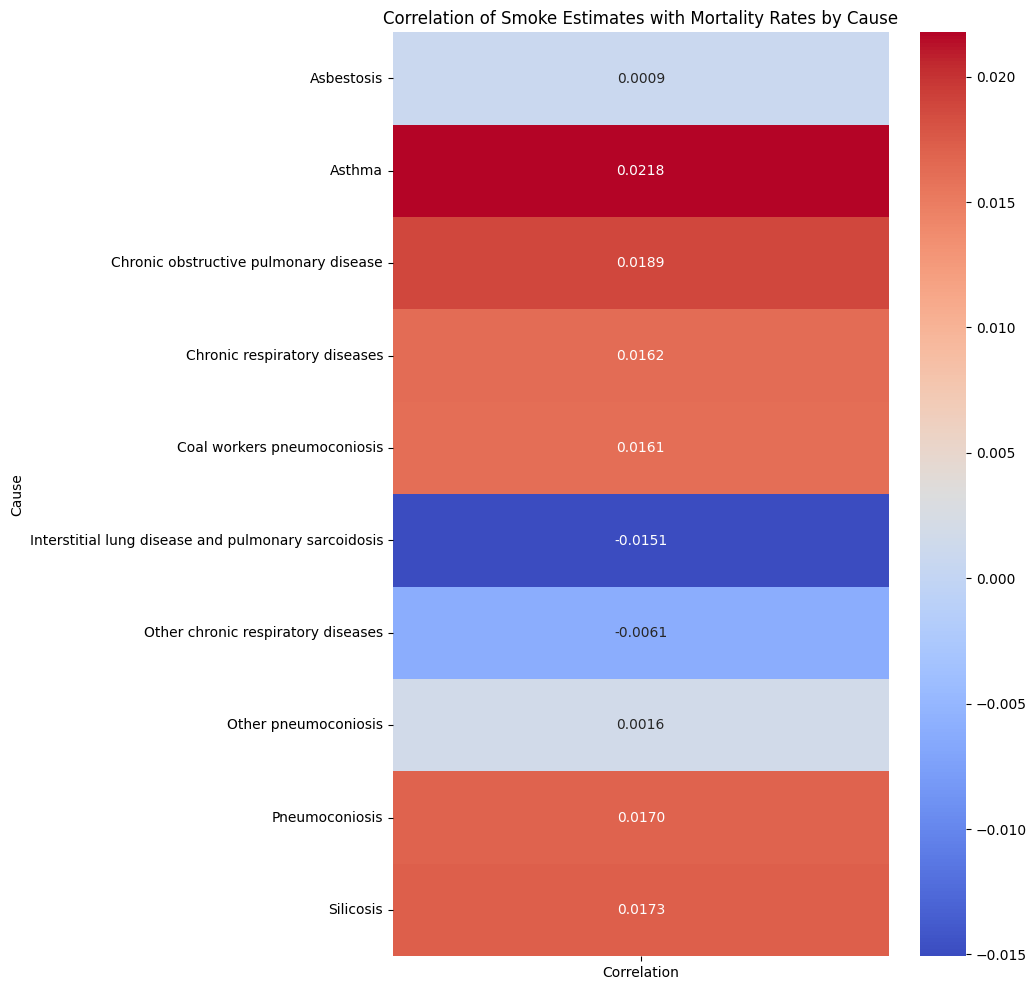

In [57]:
# Mortality data analysis

# Step 1: Prepare mortality data
mortality_data_filtered = mortality_resp_diseases_alexandria_df[['year_id', 'cause_name', 'sex', 'mx']]
mortality_data_filtered.rename(columns={'year_id': 'year'}, inplace=True)

# Step 2: Prepare smoke estimate data
smoke_data = smoke_estimates_df

# Step 3: Merge datasets
merged_data = pd.merge(mortality_data_filtered, smoke_data, on='year', how='inner')

# Step 4: Analyze correlation by gender
gender_groups = merged_data.groupby('sex')
for gender, group in gender_groups:
    correlation = group[['smoke_estimate', 'mx']].corr().iloc[0, 1]
    print(f"Correlation for {gender}: {correlation}")

# Step 5: Analyze correlation by cause
cause_groups = merged_data.groupby('cause_name')
cause_correlations = {}
for cause, group in cause_groups:
    correlation = group[['smoke_estimate', 'mx']].corr().iloc[0, 1]
    cause_correlations[cause] = correlation

# Display correlation for each cause
for cause, corr in cause_correlations.items():
    print(f"Correlation for {cause}: {corr}")


# Heatmap for cause correlations
cause_corr_df = pd.DataFrame(list(cause_correlations.items()), columns=['Cause', 'Correlation'])
cause_corr_df.set_index('Cause', inplace=True)
plt.figure(figsize=(8, 12))
sns.heatmap(cause_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt=".4f")
plt.title("Correlation of Smoke Estimates with Mortality Rates by Cause")
plt.show()


/var/folders/ld/y0zsw11s34q_fr6m889pmps40000gp/T/ipykernel_75109/4291116109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortality_data_filtered.rename(columns={'year_id': 'year'}, inplace=True)


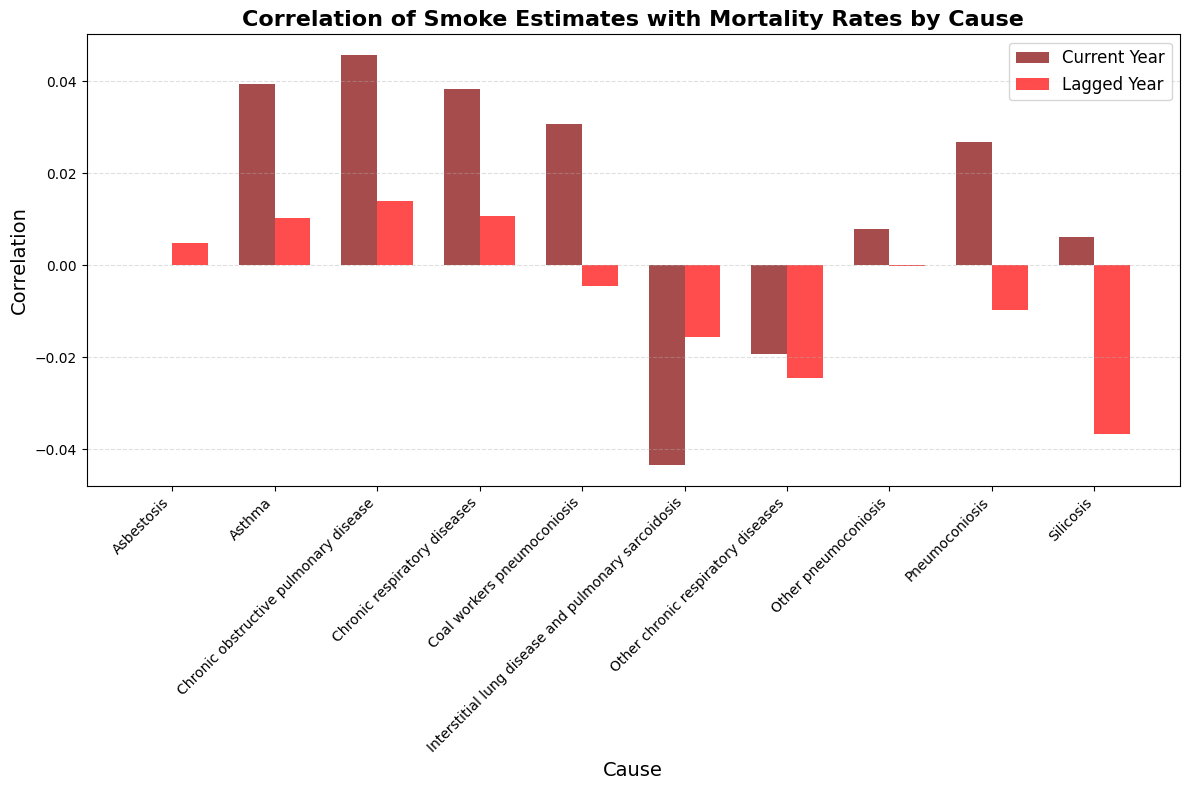

In [ ]:
# Step 1: Prepare mortality data
mortality_data_filtered = mortality_resp_diseases_alexandria_df[['year_id', 'cause_name', 'sex', 'mx']]
mortality_data_filtered.rename(columns={'year_id': 'year'}, inplace=True)

# Step 2: Prepare smoke estimate data with lag
smoke_data = smoke_estimates_df.reset_index().copy()
smoke_data['smoke_estimate_lagged'] = smoke_data['smoke_estimate'].shift(1)

# Step 3: Merge datasets
merged_data = pd.merge(mortality_data_filtered, smoke_data, on='year', how='inner')

# Step 4: Analyze correlations (current and lagged) by cause
cause_groups = merged_data.groupby('cause_name')
cause_correlations = {}
cause_lagged_correlations = {}

for cause, group in cause_groups:
    # Current year correlation
    current_correlation = group[['smoke_estimate', 'mx']].corr().iloc[0, 1]
    # Lagged year correlation
    lagged_correlation = group[['smoke_estimate_lagged', 'mx']].corr().iloc[0, 1]
    cause_correlations[cause] = current_correlation
    cause_lagged_correlations[cause] = lagged_correlation

# Step 5: Combine into a single DataFrame
correlation_df = pd.DataFrame({
    'Current Year': cause_correlations,
    'Lagged Year': cause_lagged_correlations
}).reset_index().rename(columns={'index': 'Cause'})

# Step 6: Create grouped bar plot
plt.figure(figsize=(12, 8))
bar_width = 0.35
x = range(len(correlation_df))

plt.bar(x, correlation_df['Current Year'], width=bar_width, label='Current Year', color='maroon', alpha=0.7)
plt.bar([i + bar_width for i in x], correlation_df['Lagged Year'], width=bar_width, label='Lagged Year', color='red', alpha=0.7)

# Add labels, title, and legend
plt.xticks([i + bar_width / 2 for i in x], correlation_df['Cause'], rotation=45, ha='right', fontsize=10)
plt.title('Correlation of Smoke Estimates with Mortality Rates by Cause', fontsize=16, fontweight='bold')
plt.xlabel('Cause', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.4, linestyle='--')

# Adjust layout for better readability
plt.tight_layout()
plt.show()


No long term effects of smoke on mortality

### Save data to use later by model

In [58]:
# Final data creation for model building

# mortality for asthma and COPD
# Step 1: Prepare mortality data

mortality_data_filtered = mortality_resp_diseases_alexandria_df[
    (mortality_resp_diseases_alexandria_df['cause_name'] == 'Asthma') |
    (mortality_resp_diseases_alexandria_df['cause_name'] == 'Chronic obstructive pulmonary disease')
][['cause_name', 'sex', 'mx', 'year_id']]


mortality_data_filtered.rename(columns={'year_id': 'year'}, inplace=True)

# Step 2: Prepare smoke estimate data
smoke_data = smoke_estimates_df[['year', 'smoke_estimate']]

# Step 3: Merge datasets
merged_mortality_copd_asthma_data = pd.merge(mortality_data_filtered, smoke_data, on='year', how='inner')

merged_mortality_copd_asthma_data.to_csv('../intermediary_files/mortality_asthma_copd.csv')

In [59]:
merged_mortality_copd_asthma_data.head()

,cause_name,sex,mx,year,smoke_estimate
0,Chronic obstructive pulmonary disease,Male,62.384962,1980,6.475663
1,Chronic obstructive pulmonary disease,Male,62.384962,1980,2.913322
2,Chronic obstructive pulmonary disease,Male,62.384962,1980,2.130284
3,Chronic obstructive pulmonary disease,Male,62.384962,1980,0.851539
4,Chronic obstructive pulmonary disease,Male,62.384962,1980,0.811558


In [60]:
copd_hosp_df_final = copd_hosp_df[['Year', 'Gender', 'Value']]
copd_hosp_df_final = copd_hosp_df_final.rename(columns={'Year':'year', 'Gender':'sex'})

asthma_df_final = asthma_df[['Year', 'Gender', 'Value']]
asthma_df_final = asthma_df_final.rename(columns={'Year':'year', 'Gender':'sex'})

copd_hosp_df_final['condition'] = 'COPD'
asthma_df_final['condition'] = 'Asthma'


In [61]:
# Concatenate the two DataFrames
merged_hosp_copd_asthma_data = pd.concat([copd_hosp_df_final, asthma_df_final], ignore_index=True)

# Step 3: Merge datasets
merged_hosp_smoke_copd_asthma_data = pd.merge(merged_hosp_copd_asthma_data, smoke_data, on='year', how='inner')

merged_hosp_smoke_copd_asthma_data.to_csv('../intermediary_files/mortality_asthma_copd.csv')

In [62]:
merged_hosp_smoke_copd_asthma_data.to_csv('../intermediary_files/hospitalization_asthma_copd.csv')

In [63]:
merged_hosp_smoke_copd_asthma_data.head()

,year,sex,Value,condition,smoke_estimate
0,2010,Male,9.9,COPD,30.668830
1,2010,Male,9.9,COPD,8.707322
2,2010,Male,9.9,COPD,2.119830
3,2010,Male,9.9,COPD,22.389660
4,2010,Male,9.9,COPD,16.201209
